# PDFxTMDLib Python Tutorial
Welcome! This notebook demonstrates the main features of the PDFxTMD Python bindings, including collinear PDFs (CPDF), TMDs, and QCD coupling.


## Installation
```bash
pip install pdfxtmd
```

API Reference: https://github.com/Raminkord92/PDFxTMD

In [ ]:
!pip install pdfxtmd


## 2. Imports

Import the required libraries:

In [83]:
import pdfxtmd
import platform
import os
import yaml
import tarfile
import requests
import numpy as np
import matplotlib.pyplot as plt

## 3. Configuration: Setting PDFxTMD Paths

PDFxTMDLib uses a config file to store paths to PDF/TMD sets. The following functions help you manage these paths.


In [78]:
# Default paths:
# Linux: /usr/local/share/PDFxTMDLib
# Windows: C:\ProgramData\PDFxTMDLib\config.yaml
def get_config_path():
    """Get the system-specific config file path."""
    if platform.system() == "Linux":
        return os.path.expanduser("~/.PDFxTMDLib/config.yaml")
    elif platform.system() == "Windows":
        return os.path.join(os.environ.get('PROGRAMDATA', 'C:\\ProgramData'), 
                          'PDFxTMDLib', 'config.yaml')
    else:
        raise OSError(f"Unsupported operating system: {platform.system()}")


**List current PDFxTMD paths:**

In [ ]:
def list_pdfxtmd_paths():
    """
    Reads the 'paths' entry from config.yaml and returns the list of paths.
    Creates config file with default path if it doesn't exist.
    """
    config_path = get_config_path()
    config_dir = os.path.dirname(config_path)
    
    try:
        # Create config directory if it doesn't exist
        if not os.path.exists(config_dir):
            os.makedirs(config_dir)
            
        # Create default config if file doesn't exist
        if not os.path.exists(config_path):
            default_config = {
                'paths': '"/usr/local/share/PDFxTMDLib"'
            }
            with open(config_path, 'w') as file:
                yaml.dump(default_config, file, default_flow_style=False)
            print(f"Created new config file at {config_path}")
            
        # Read config file
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file) or {}
        current_path = config.get('paths', '')
        
        # Remove quotes and split by '|'
        paths = [p for p in current_path.strip('"').split('|') if p]
        print("Configured PDFxTMD paths:")
        for p in paths:
            print(" ", p)
        return paths
            
    except Exception as e:
        print(f"Error handling config.yaml: {e}")
        return []

In [52]:
list_pdfxtmd_paths()

Configured PDFxTMD paths:
  /home/PDFxTMDSets
  /home/PDFxTMDSets1


['/home/PDFxTMDSets', '/home/PDFxTMDSets1']

**Add a new path:**

In [74]:
def add_pdfxtmd_path(new_path):
    """
    Add new_path to the 'paths' entry in config.yaml, separated by '|', 
    and avoid duplicates. All paths are wrapped in a single pair of quotes.
    Handles empty or missing 'paths' entries.
    """
    config_path = get_config_path()
    new_path = os.path.expanduser(new_path)

    try:
        # Read existing config
        if os.path.exists(config_path):
            with open(config_path, 'r') as file:
                config = yaml.safe_load(file) or {}
        else:
            config = {}
        
        # Handle None or missing paths
        current_path = config.get('paths') or ''
        if current_path is None:
            current_path = ''
            
        # Strip any existing quotes and split
        current_path = current_path.strip('"')
        paths = [p for p in current_path.split('|') if p.strip()]
        
        # Add new path if not present
        if new_path not in paths:
            paths.append(new_path)
        
        # Join paths and wrap in quotes
        updated_path = f'"{"|".join(paths)}"'

        # Write back to config using literal string style
        with open(config_path, 'w') as file:
            file.write(f"paths: {updated_path}\n")
        print(f"Updated {config_path} with paths:\n{updated_path}")
    except Exception as e:
        print(f"Error updating config.yaml: {e}")

In [76]:
add_pdfxtmd_path('/home/PDFxTMDSets1')
list_pdfxtmd_paths()

Updated /root/.PDFxTMDLib/config.yaml with paths:
"/home/PDFxTMDSets|/home/PDFxTMDSets1"
Configured PDFxTMD paths:
  /home/PDFxTMDSets
  /home/PDFxTMDSets1


['/home/PDFxTMDSets', '/home/PDFxTMDSets1']

## 4. Downloading PDF and TMD Sets

You can download PDF and TMD sets directly from LHAPDF and TMDLib.

In [ ]:
def normalize_pdfset_name(pdfset_name):
    """
    Replace '+' with '%2B' and '=' with '%3D' to match LHAPDF/TMDLib URL encoding.
    """
    return pdfset_name.replace('+', '%2B').replace('=', '%3D')

def DownloadcPDF(PDFSetName, dest_dir=None):
    """
    Download a collinear PDF set from LHAPDF and extract it to dest_dir.
    If dest_dir is None or empty, use the first path in PDFxTMD paths with read-write access.
    """
    PDFSetName = normalize_pdfset_name(PDFSetName)
    # Determine destination directory
    if not dest_dir:
        # Try to get PDFxTMD paths from config
        pdfxtmd_paths = list_pdfxtmd_paths()
        for path in pdfxtmd_paths:
            expanded_path = os.path.expanduser(path)
            try:
                os.makedirs(expanded_path, exist_ok=True)
                if os.access(expanded_path, os.W_OK | os.R_OK):
                    dest_dir = expanded_path
                    break
            except Exception:
                continue
        if not dest_dir:
            print("No writable PDFxTMD path found.")
            return False
    else:
        dest_dir = os.path.expanduser(dest_dir)
        os.makedirs(dest_dir, exist_ok=True)

    url = f"http://lhapdfsets.web.cern.ch/lhapdfsets/current/{PDFSetName}.tar.gz"
    local_tar = os.path.join(dest_dir, f"{PDFSetName}.tar.gz")
    print(f"Downloading {PDFSetName} from LHAPDF...")
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        print(f"Failed to download {PDFSetName}: HTTP {r.status_code}")
        return False
    with open(local_tar, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Extracting {local_tar}...")
    try:
        with tarfile.open(local_tar, "r:gz") as tar:
            tar.extractall(dest_dir)
        print(f"Extracted to {dest_dir}")
        os.remove(local_tar)
        return True
    except Exception as e:
        print(f"Extraction failed: {e}")
        return False

def DownloadTMD(TMDName, dest_dir=None):
    """
    Download a TMD set from TMDLib and extract it to dest_dir.
    If dest_dir is None or empty, use the first path in PDFxTMD paths with read-write access.
    """
    TMDName = normalize_pdfset_name(TMDName)
    # Determine destination directory
    if not dest_dir:
        pdfxtmd_paths = list_pdfxtmd_paths()
        for path in pdfxtmd_paths:
            expanded_path = os.path.expanduser(path)
            try:
                os.makedirs(expanded_path, exist_ok=True)
                if os.access(expanded_path, os.W_OK | os.R_OK):
                    dest_dir = expanded_path
                    break
            except Exception:
                continue
        if not dest_dir:
            print("No writable PDFxTMD path found.")
            return False
    else:
        dest_dir = os.path.expanduser(dest_dir)
        os.makedirs(dest_dir, exist_ok=True)

    url = ("https://syncandshare.desy.de/index.php/s/GjjcwKQC93M979e/download"
           f"?path=%2FTMD%20grid%20files&files={TMDName}.tgz")
    local_tar = os.path.join(dest_dir, f"{TMDName}.tgz")
    print(f"Downloading {TMDName} from TMDLib...")
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        print(f"Failed to download {TMDName}: HTTP {r.status_code}")
        return False
    with open(local_tar, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Extracting {local_tar}...")
    try:
        with tarfile.open(local_tar, "r:gz") as tar:
            tar.extractall(dest_dir)
        print(f"Extracted to {dest_dir}")
        os.remove(local_tar)
        return True
    except Exception as e:
        print(f"Extraction failed: {e}")
        return False

**Download example sets:**

In [ ]:
DownloadcPDF('CT18NLO')
DownloadTMD('PB-LO-HERAI+II-2020-set2')

Configured PDFxTMD paths:
  /home/PDFxTMDSets
  /home/PDFxTMDSets1


KeyboardInterrupt: 

## 5. Using Collinear PDFs (CPDF)


In [77]:
# 1. Create a CPDF factory and CPDF object
cpdf_factory = pdfxtmd.GenericCPDFFactory()
cpdf = cpdf_factory.mkCPDF("CT18NLO", 0)

# 2. Evaluate a single flavor
x = 0.01
mu2 = 100
print("Up quark PDF:", cpdf.pdf(pdfxtmd.PartonFlavor.u, x, mu2))
print("Gluon PDF:", cpdf.pdf(pdfxtmd.PartonFlavor.g, x, mu2))

Up quark PDF: 0.6328219234466192
Gluon PDF: 6.608099666078711


In [3]:
# 3. Evaluate all flavors at once (output is modified in-place)
all_flavors = []
cpdf.pdf(x, mu2, all_flavors)
print("All flavors (CPDF):", all_flavors)

All flavors (CPDF): [0.0, 0.0745067960604024, 0.22351840696719444, 0.31756791282919644, 0.4256556863044601, 0.44947710355455006, 6.608099666078711, 0.5655598158877069, 0.6328219234466192, 0.31756791282919644, 0.22351840696719444, 0.0745067960604024, 0.0]


## 6. Using TMD PDFs

In [4]:
# 4. Create a TMD factory and TMD object
tmd_factory = pdfxtmd.GenericTMDFactory()
tmd = tmd_factory.mkTMD("PB-LO-HERAI+II-2020-set2", 0)

# 5. Evaluate a single flavor TMD
kt2 = 10
print("Gluon TMD:", tmd.tmd(pdfxtmd.PartonFlavor.g, x, kt2, mu2))
print("Up quark TMD:", tmd.tmd(pdfxtmd.PartonFlavor.u, x, kt2, mu2))

Gluon TMD: 0.13474574040434684
Up quark TMD: 0.009341996739134254


In [5]:
# 6. Evaluate all TMD flavors at once (output is modified in-place)
all_tmd_flavors = []
tmd.tmd(x, kt2, mu2, all_tmd_flavors)
print("All flavors (TMD):", all_tmd_flavors)

All flavors (TMD): [0.0, 0.0024451247364954804, 0.004392603063418341, 0.005442322636922362, 0.006429461593222029, 0.006653643763002118, 0.13474574040434684, 0.008261442883475566, 0.009341996739134254, 0.0054438535119338115, 0.004390853023460926, 0.0024434170707238233, 0.0]


## 7. QCD Coupling

In [6]:
# 7. Create a coupling factory and coupling object
coupling_factory = pdfxtmd.CouplingFactory()
coupling = coupling_factory.mkCoupling("CT18NLO")

# 8. Evaluate alpha_s at different scales
for scale in [10, 100, 1000, 10000]:
    print(f"Alpha_s at mu2={scale}:", coupling.AlphaQCDMu2(scale))

Alpha_s at mu2=10: 0.2476363039982271
Alpha_s at mu2=100: 0.17799804146034026
Alpha_s at mu2=1000: 0.140581925550369
Alpha_s at mu2=10000: 0.11641802733180297


## 8. Error Handling Examples

In [7]:
try:
    # Invalid x (should raise an error)
    cpdf.pdf(pdfxtmd.PartonFlavor.u, -0.1, mu2)
except Exception as e:
    print("Expected error for invalid x in CPDF:", e)

try:
    # Invalid kt2 (should raise an error)
    tmd.tmd(pdfxtmd.PartonFlavor.g, x, -5, mu2)
except Exception as e:
    print("Expected error for invalid kt2 in TMD:", e)

try:
    # Invalid mu2 (should raise an error)
    coupling.AlphaQCDMu2(-1)
except Exception as e:
    print("Expected error for invalid mu2 in Coupling:", e)

Expected error for invalid x in CPDF: Error evaluating CPDF for flavor 2 at x=-0.100000, mu2=100.000000: Momentum fraction x must be in (0, 1)
Expected error for invalid kt2 in TMD: Error evaluating TMD for flavor 21 at x=0.010000, kt2=-5.000000, mu2=100.000000: Transverse momentum squared kt2 must be non-negative
Expected error for invalid mu2 in Coupling: Error calculating alpha_s at mu2=-1.000000: Factorization scale squared (mu2) must be positive


## 9. Enumerate all PartonFlavor values

In [8]:
print("All PartonFlavor enum values:")
for name, flavor in pdfxtmd.PartonFlavor.__members__.items():
    print(f"  {name}: {flavor.value}")

All PartonFlavor enum values:
  u: 2
  d: 1
  s: 3
  c: 4
  b: 5
  t: 6
  g: 21
  ubar: -2
  dbar: -1
  sbar: -3
  cbar: -4
  bbar: -5
  tbar: -6


In [90]:
def plot_pdf_vs_x(cpdf, flavors, mu2=100, x_min=1e-4, x_max=0.9, n_points=100):
    """
    Plot PDFs as a function of x for given flavors at fixed mu2.
    """
    x_vals = np.logspace(np.log10(x_min), np.log10(x_max), n_points)
    plt.figure(figsize=(7,5))
    for flavor in flavors:
        y = [cpdf.pdf(flavor, x, mu2) for x in x_vals]
        plt.plot(x_vals, y, label=flavor.name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$f(x, \mu^2)$', fontsize=14)
    plt.title(f'PDFs at $\\mu^2={mu2}$', fontsize=15)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_pdf_vs_mu2(cpdf, flavors, x=0.01, mu2_min=1, mu2_max=1e4, n_points=100):
    """
    Plot PDFs as a function of mu2 for given flavors at fixed x.
    """
    mu2_vals = np.logspace(np.log10(mu2_min), np.log10(mu2_max), n_points)
    plt.figure(figsize=(7,5))
    for flavor in flavors:
        y = [cpdf.pdf(flavor, x, mu2) for mu2 in mu2_vals]
        plt.plot(mu2_vals, y, label=flavor.name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\mu^2$', fontsize=14)
    plt.ylabel(r'$f(x, \mu^2)$', fontsize=14)
    plt.title(f'PDFs at $x={x}$', fontsize=15)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_tmd_vs_x(tmd, flavors, kt2=10, mu2=100, x_min=1e-4, x_max=0.9, n_points=100):
    """
    Plot TMDs as a function of x for given flavors at fixed kt2 and mu2.
    """
    x_vals = np.logspace(np.log10(x_min), np.log10(x_max), n_points)
    plt.figure(figsize=(7,5))
    for flavor in flavors:
        y = [tmd.tmd(flavor, x, kt2, mu2) for x in x_vals]
        plt.plot(x_vals, y, label=flavor.name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$f(x, k_T^2, \mu^2)$', fontsize=14)
    plt.title(f'TMDs at $k_T^2={kt2}$, $\\mu^2={mu2}$', fontsize=15)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_tmd_vs_kt2(tmd, flavors, x=0.01, mu2=100, kt2_min=1, kt2_max=100, n_points=100):
    """
    Plot TMDs as a function of kt2 for given flavors at fixed x and mu2.
    """
    kt2_vals = np.logspace(np.log10(kt2_min), np.log10(kt2_max), n_points)
    plt.figure(figsize=(7,5))
    for flavor in flavors:
        y = [tmd.tmd(flavor, x, kt2, mu2) for kt2 in kt2_vals]
        plt.plot(kt2_vals, y, label=flavor.name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$k_T^2$', fontsize=14)
    plt.ylabel(r'$f(x, k_T^2, \mu^2)$', fontsize=14)
    plt.title(f'TMDs at $x={x}$, $\\mu^2={mu2}$', fontsize=15)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_tmd_vs_mu2(tmd, flavors, x=0.01, kt2=10, mu2_min=5, mu2_max=1e4, n_points=100):
    """
    Plot TMDs as a function of mu2 for given flavors at fixed x and kt2.
    """
    mu2_vals = np.logspace(np.log10(mu2_min), np.log10(mu2_max), n_points)
    plt.figure(figsize=(7,5))
    for flavor in flavors:
        y = [tmd.tmd(flavor, x, kt2, mu2) for mu2 in mu2_vals]
        plt.plot(mu2_vals, y, label=flavor.name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\mu^2$', fontsize=14)
    plt.ylabel(r'$f(x, k_T^2, \mu^2)$', fontsize=14)
    plt.title(f'TMDs at $x={x}$, $k_T^2={kt2}$', fontsize=15)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

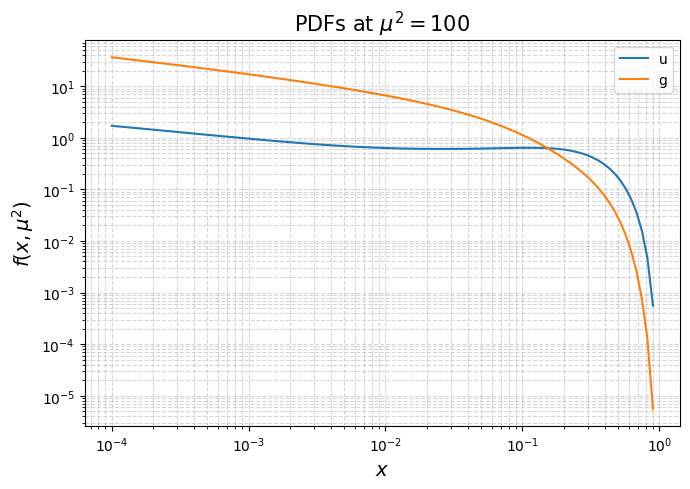

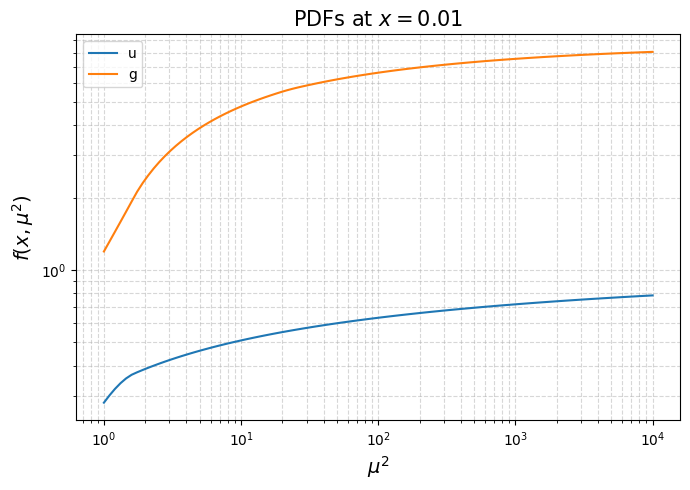

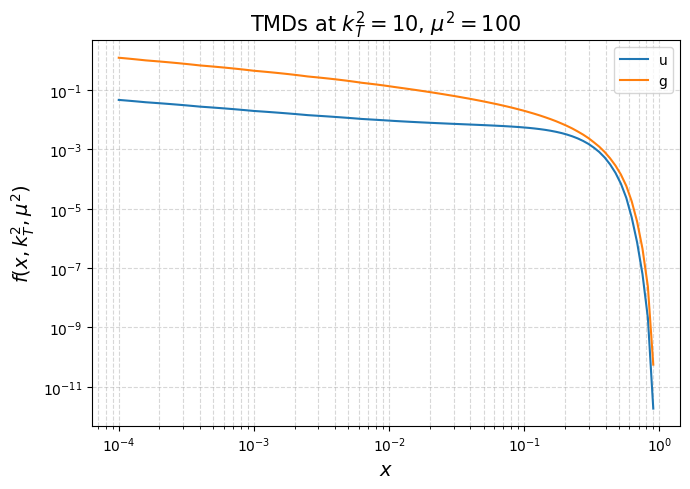

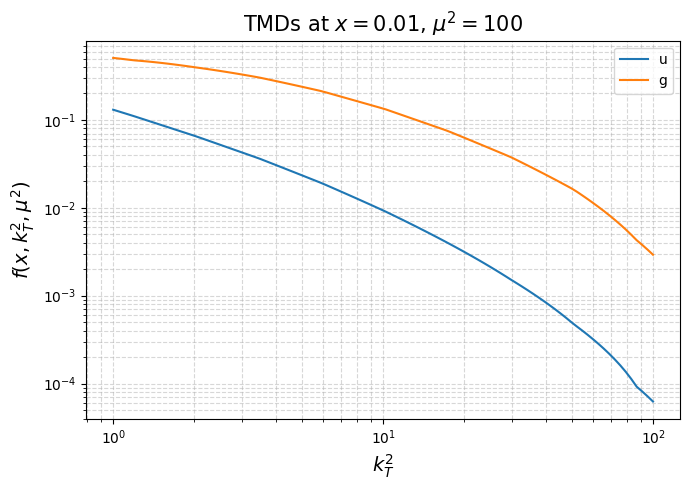

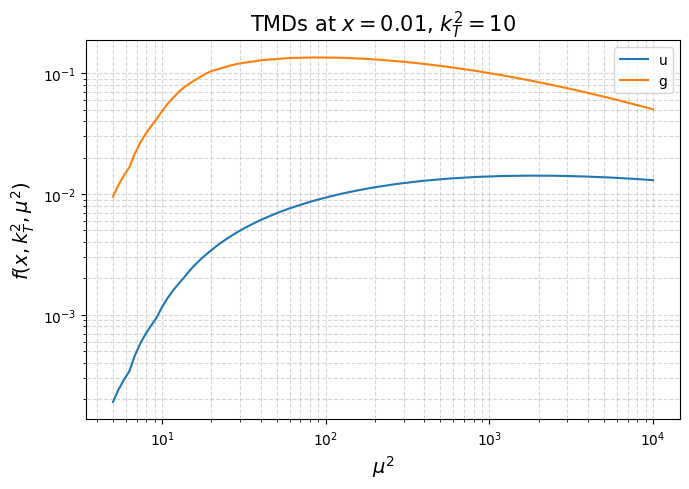

In [91]:
# Example: Plot PDFs as a function of x for up quark and gluon
plot_pdf_vs_x(cpdf, [pdfxtmd.PartonFlavor.u, pdfxtmd.PartonFlavor.g], mu2=100)

# Example: Plot PDFs as a function of mu2 for up quark and gluon
plot_pdf_vs_mu2(cpdf, [pdfxtmd.PartonFlavor.u, pdfxtmd.PartonFlavor.g], x=0.01)

# Example: Plot TMDs as a function of x for up quark and gluon
plot_tmd_vs_x(tmd, [pdfxtmd.PartonFlavor.u, pdfxtmd.PartonFlavor.g], kt2=10, mu2=100)

# Example: Plot TMDs as a function of kt2 for up quark and gluon
plot_tmd_vs_kt2(tmd, [pdfxtmd.PartonFlavor.u, pdfxtmd.PartonFlavor.g], x=0.01, mu2=100)

# Example: Plot TMDs as a function of mu2 for up quark and gluon
plot_tmd_vs_mu2(tmd, [pdfxtmd.PartonFlavor.u, pdfxtmd.PartonFlavor.g], x=0.01, kt2=10)